In [3]:
!pip install torchvision 

  Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl (1.6 MB)



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Libraries

In [42]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt  # Add this import
import requests
import json

In [53]:
# --- Configuration ---
dataset_path = "finger_dataset"  # Path to your dataset
API_KEY = "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"  # Your OpenRouter API key
MODEL = "openai/gpt-4o"  # Updated to a likely available vision model (check OpenRouter’s model list)

In [44]:
# --- Step 1: Load and Prepare Dataset ---
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path {dataset_path} does not exist")

## Define Data Augmentation

In [45]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.RandomRotation(20),  # Rotate randomly
    transforms.RandomHorizontalFlip(),  # Flip horizontally
    transforms.ToTensor()  # Convert images to tensors
])


## Load DataSet

Class Labels: {'Five_Finger_Up': 0, 'Four_Finger_Roll': 1, 'One_Finger_Right': 2, 'Three_Finger_Start': 3, 'Two_Finger_Left': 4}
Displaying images for: Five_Finger_Up


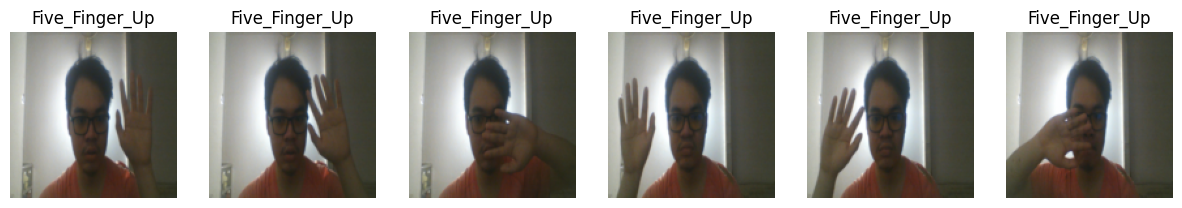

Displaying images for: Four_Finger_Roll


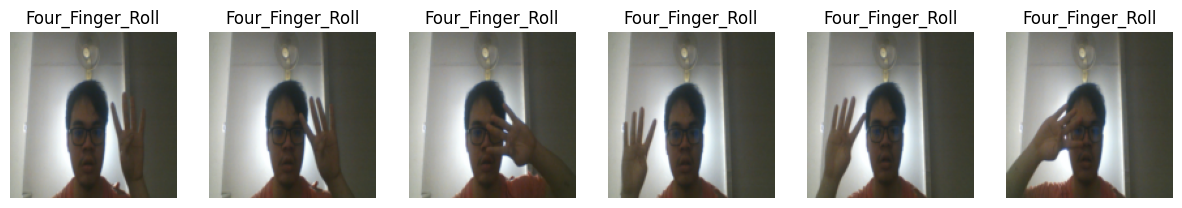

Displaying images for: One_Finger_Right


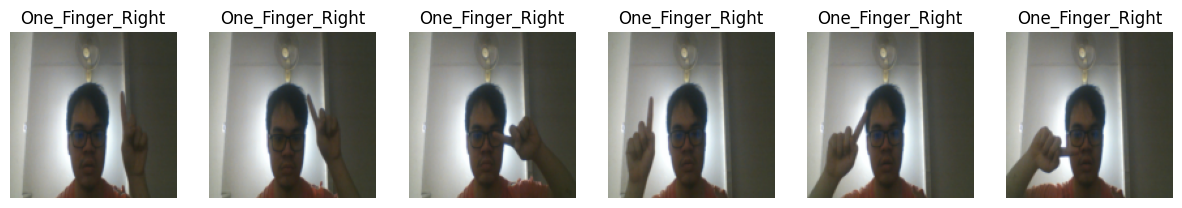

Displaying images for: Three_Finger_Start


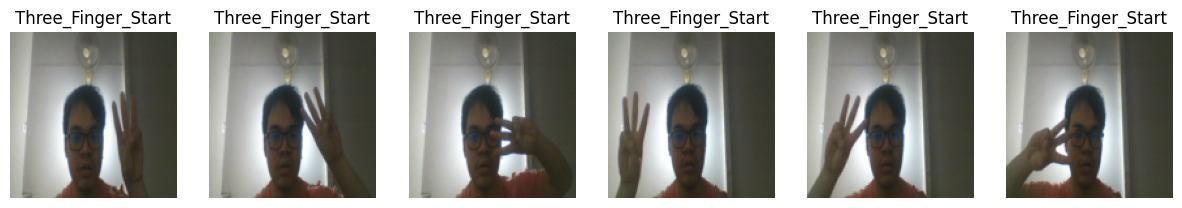

Displaying images for: Two_Finger_Left


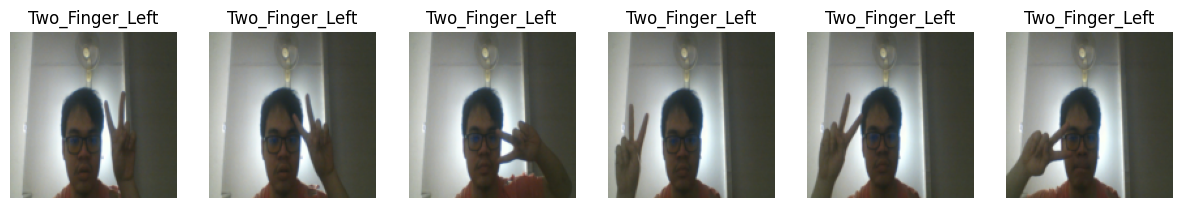

In [46]:
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Define dataset path
dataset_path = "finger_dataset"

# Define transformations (Resize + Convert to Tensor)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor()  # Convert to tensor
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  # Load one image at a time

# Get class names
class_labels = dataset.class_to_idx  # Example: {'Five_Finger_Up': 0, 'Four_Finger_Roll': 1, ...}
print("Class Labels:", class_labels)

# Loop through the dataset and display images with class names
for class_name, class_idx in class_labels.items():
    print(f"Displaying images for: {class_name}")
    
    # Find the indices of images in this class
    image_indices = [idx for idx, label in enumerate(dataset.targets) if label == class_idx]
    
    # Display images for this class
    fig, axes = plt.subplots(1, len(image_indices), figsize=(15, 5))  # Adjust layout

    for idx, img_idx in enumerate(image_indices):
        img, label = dataset[img_idx]
        axes[idx].imshow(img.permute(1, 2, 0))  # Convert tensor to image
        axes[idx].axis("off")
        axes[idx].set_title(f"{class_name}")  # Add title to the image

    plt.show()


## Prepare Data for DeepSeek API

In [47]:
import os
import base64
import json

# Function to encode image to base64
def encode_image(image_path):
    try:
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode("utf-8")
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None


In [48]:
# Prepare dataset as a list of dictionaries
train_data = []
for class_name, label in class_labels.items():
    class_folder = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        image_base64 = encode_image(image_path)
        if image_base64:
            train_data.append({
                "image": image_base64,
                "label": label,
                "path": image_path  # Store path for reference
            })

print(f"Prepared {len(train_data)} images for processing.")

Prepared 30 images for processing.


In [50]:
# --- Step 2: Send to OpenRouter API ---
def send_to_openrouter(image_base64, label, class_names):
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json",
    }
    
    # Map label back to class name
    idx_to_class = {v: k for k, v in class_names.items()}
    true_label = idx_to_class[label]
    
    # Prompt for classification
    class_list = ", ".join(class_names.keys())
    prompt = f"Classify this hand gesture image into one of these categories: {class_list}. Provide only the category name as the response."
    
    payload = {
        "model": MODEL,
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]
            }
        ],
        "max_tokens": 10  # Limit response to a short classification
    }
    
    try:
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"].strip()
        else:
            print(f"API Error: {response.status_code} - {response.text}")
            return None
    except Exception as e:
        print(f"Request failed: {e}")
        return None

In [54]:
# --- Step 3: Process Dataset and Evaluate ---
correct = 0
total = 0
results = []

for i, sample in enumerate(train_data):
    image_base64 = sample["image"]
    label = sample["label"]
    image_path = sample["path"]
    idx_to_class = {v: k for k, v in class_labels.items()}
    true_label = idx_to_class[label]
    
    # Send to OpenRouter
    predicted_label = send_to_openrouter(image_base64, label, class_labels)
    if predicted_label:
        # Check if prediction matches true label
        is_correct = predicted_label == true_label
        correct += 1 if is_correct else 0
        total += 1
        
        # Store result
        results.append({
            "image_path": image_path,
            "true_label": true_label,
            "predicted_label": predicted_label,
            "correct": is_correct
        })
        
        # Print progress
        print(f"Sample {i+1}/{len(train_data)}: True={true_label}, Predicted={predicted_label}, Correct={is_correct}")
    else:
        print(f"Sample {i+1}/{len(train_data)}: Failed to get prediction for {image_path}")

Sample 1/30: True=Five_Finger_Up, Predicted=Five_Finger_Up, Correct=True
Sample 2/30: True=Five_Finger_Up, Predicted=Five_Finger_Up, Correct=True
Sample 3/30: True=Five_Finger_Up, Predicted=Five_Finger_Up, Correct=True
Sample 4/30: True=Five_Finger_Up, Predicted=Five_Finger_Up, Correct=True
Sample 5/30: True=Five_Finger_Up, Predicted=Five_Finger_Up, Correct=True
Sample 6/30: True=Five_Finger_Up, Predicted=Five_Finger_Up, Correct=True
Sample 7/30: True=Four_Finger_Roll, Predicted=Four_Finger_Roll, Correct=True
Sample 8/30: True=Four_Finger_Roll, Predicted=Four_Finger_Roll, Correct=True
Sample 9/30: True=Four_Finger_Roll, Predicted=Three_Finger_Start, Correct=False
Sample 10/30: True=Four_Finger_Roll, Predicted=Four_Finger_Roll, Correct=True
Sample 11/30: True=Four_Finger_Roll, Predicted=Four_Finger_Roll, Correct=True
Sample 12/30: True=Four_Finger_Roll, Predicted=Five_Finger_Up, Correct=False
Sample 13/30: True=One_Finger_Right, Predicted=One_Finger_Right, Correct=True
Sample 14/30: Tru

In [55]:
# --- Step 4: Summary ---
if total > 0:
    accuracy = 100 * correct / total
    print(f"\nSummary:")
    print(f"Total images processed: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Accuracy: {accuracy:.2f}%")
else:
    print("No images were successfully processed.")

# Optionally save results to a file
with open("classification_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Results saved to 'classification_results.json'")


Summary:
Total images processed: 30
Correct predictions: 26
Accuracy: 86.67%
Results saved to 'classification_results.json'


In [ ]:
# import requests
# import json

# API_KEY = "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"

In [ ]:
# response = requests.post(
#     url="https://openrouter.ai/api/v1/chat/completions",
#     headers={
#         "Authorization": f"Bearer {API_KEY}",
#         "Content-Type": "application/json",
#         # Optional headers (uncomment if needed):
#         # "HTTP-Referer": "https://mywebsite.com",
#         # "X-Title": "My Cool Site",
#     },
# )

In [ ]:
# # Check and print the response
# if response.status_code == 200:
#     print("Training started successfully!")
#     response_data = response.json()
    
#     # Print the entire response to see its structure
#     print("Full Response:", json.dumps(response_data, indent=2))
    
#     # Extract the model ID from the "id" key
#     model_id = response_data.get("id")  # Adjusted to "id"
#     if model_id:
#         print(f"Model ID: {model_id}")
#     else:
#         print("Model ID not found in the response.")
# else:
#     print(f"Error: {response.status_code} - {response.text}")

Training started successfully!
Full Response: {
  "id": "gen-1740377839-UTsKmWSMDdEu0F2FSkLb",
  "provider": "Chutes",
  "model": "deepseek/deepseek-r1",
  "object": "chat.completion",
  "created": 1740377839,
  "choices": [
    {
      "logprobs": null,
      "finish_reason": "stop",
      "native_finish_reason": "stop",
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "The question of life's meaning is profound and multifaceted, with diverse perspectives across philosophy, religion, science, and personal experience. Here's a synthesis of key viewpoints:\n\n1. **Philosophical Perspectives**:  \n   - **Existentialism**: Thinkers like Jean-Paul Sartre and Albert Camus suggest that life has no inherent meaning, but this freedom allows us to *create our own purpose* through choices, passions, and commitments.  \n   - **Absurdism**: Camus also proposed that embracing the \"absurd\" (the clash between our search for meaning and an indifferent universe) ca